In [89]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import json
import matplotlib.pyplot as plt
import numpy as np

import recova.learning_dataset
from recova.learning.learning import model_from_file
from recova.util import wishart_kl_divergence

np.set_printoptions(precision=3, linewidth=100)

In [161]:
DATASET_FILE = '/home/david/dataset/learning_sets/2018-08-11-inside.json'
LEARNING_RUN_FILE = '/home/david/dataset/learning_runs/2018-08-13-stairs.json'
MODEL_FILE = '/home/david/dataset/learning_runs/2018-08-13-stairs.model'

In [162]:
with open(DATASET_FILE) as f:
    dataset = json.load(f)
    
with open(LEARNING_RUN_FILE) as f:
    learning_run = json.load(f)
    
model = model_from_file(MODEL_FILE, 'cello')

In [163]:
xs = np.array(dataset['data']['xs'])
ys = np.array(dataset['data']['ys'])


train_set = learning_run['train_set']
validation_set = learning_run['validation_set']

In [164]:
validation_xs = xs[validation_set]
validation_ys = ys[validation_set]

In [165]:
predictions = model.predict(validation_xs)

6
6


In [166]:
reference_norms = np.zeros(len(predictions))
prediction_norms = np.zeros(len(predictions))
norm_loss = np.zeros(len(predictions))
wishart_kl = np.zeros(len(predictions))
gaussian_kl = np.zeros(len(predictions))
percent_loss = np.zeros(len(predictions))

for i in range(len(predictions)):
    reference_norms[i] = np.linalg.norm(ys[validation_set[i]])
    prediction_norms[i] = np.linalg.norm(predictions[i])
    wishart_kl[i] = wishart_kl_divergence(ys[validation_set[i]], 6, predictions[i], 6)
    norm_loss[i] = np.linalg.norm(ys[validation_set[i]] - predictions[i])
    percent_loss = abs(norm_loss[i] / np.linalg.norm(ys[validation_set[i]]))
    gaussian_kl[i] = kullback_leibler(ys[validation_set[i]], predictions[i])

4.17092447603087e-55
3.597862804761273e-39
5.785073098412842e-56
2.2962464905056532e-37
4.8266963632270665e-56
4.5261589020958016e-45
5.806828675067012e-55
1.3443071244345071e-33
1.2362271651686427e-55
4.2289820766595204e-33
5.764316583280192e-55
6.3569859214705235e-34
3.4543528293693577e-54
1.6911448848610268e-32
6.361930590730746e-55
1.5467902812939775e-33
4.738871831737793e-56
1.1156255696610386e-39
3.37252276691149e-56
4.230074652008826e-44
3.082203562376185e-54
7.240816520521157e-33
6.1099414997157955e-55
3.0396012752347465e-34
2.4103734183712583e-55
8.278268568729698e-36
3.257103420615596e-56
3.288848211621578e-35
5.006184001233873e-56
4.2800961054145427e-39
7.12139640913105e-53
3.4090419532956025e-35
2.41560406910651e-55
1.6807957883743875e-35
1.2016486709830878e-55
5.893596853694011e-36
2.4530344589969385e-55
1.3612767063527014e-35
1.2580905247399071e-55
1.295803174294835e-36
2.200693843664794e-53
2.4307236075722577e-34
2.1659117208073186e-53
5.729955127066784e-32
2.26429806072

1.747999590867986e-57
6.190440124462508e-32
2.965949362362283e-54
3.0146775070425356e-32
2.895896525466214e-54
9.098999773702052e-33
1.0084100671331421e-54
1.1459153561074323e-32
4.9430700589235505e-56
1.7581625746853349e-31
1.1767587044476682e-56
1.9518185201340965e-34
4.310988840020612e-55
6.73170906981042e-34
4.2297374064182577e-54
3.448778590353359e-34
2.8095878826559706e-54
5.965954014553195e-33
1.298317137501165e-54
1.6894966933302334e-33
3.156825827389272e-54
1.3865165686557486e-34
6.1132905362233715e-56
9.65469997231774e-33
8.076095728109909e-56
1.0884318255121454e-32
1.3785578803701537e-55
1.63632889578554e-33
5.736800926675804e-56
5.119529375682111e-33
1.2535010406358581e-54
1.7698022109478284e-32
1.015606734123993e-55
5.736308807252959e-33
1.384710783065874e-55
1.5964527564814109e-32
4.3107611261518176e-54
3.21154056093928e-31
1.9915484454042146e-55
3.632625113687023e-32
7.476666113913012e-55
5.497863895118752e-32
3.7593292729795287e-54
1.9216531327072267e-30
1.4732269258337

1.1915022731164562e-42
2.2056767433553866e-46
1.1984334209356616e-42
3.79628307835635e-42
1.2178411517668893e-42
1.443343758532416e-45
1.2215639252361786e-42
3.168397943378342e-47
1.8382123929522207e-45
6.921538130981117e-47
1.8651431428396962e-45
1.3760067620504982e-47
1.8614078273080673e-45
2.3231471165298144e-46
6.810992666625538e-51
8.611744909869475e-44
1.845826548710458e-45
1.8637093825434916e-44
6.552373333729288e-51
1.9580658604191416e-44
6.184952289145861e-51
4.3003922185263746e-42
6.449515456566844e-51
1.456468307332889e-42
1.211107776239e-40
5.106179932046771e-40
1.853779380154117e-45
9.79423588860259e-48
1.8551192542269764e-45
3.617377351188744e-48
1.882169144453629e-45
8.436025378631806e-45
1.2146920557310897e-40
2.685834375530497e-36
1.212079291002624e-40
2.6985223188265077e-36
1.2056948885239627e-40
2.8569682462320124e-36
6.461769259098823e-51
4.215345402126818e-45
4.8411914790948875e-43
3.933996989145076e-37
4.8877622761479915e-43
3.082406298895107e-40
1.208138238953971

1.9338377526461795e-49
2.5972994234693027e-38
7.108589620568207e-49
1.2783115840859434e-39
8.170956523173308e-52
4.779615471104545e-41
2.2921508630214992e-48
3.411235129350476e-39
2.5785377128758223e-48
1.473737842231315e-39
6.883535476869802e-49
2.1498716254828344e-39
2.3769872163523773e-48
3.892306862000217e-39
2.3502438929158204e-48
2.761909568208199e-39
1.621984379464926e-47
4.235592236220929e-40
6.224453800682477e-49
1.0256686226580785e-39
1.6367960941576599e-47
3.86379291343883e-40
1.6696068170927676e-47
3.6719092827017316e-40
1.6026456576212635e-47
1.1027248181616321e-40
1.6008168116398234e-47
1.3924651295422285e-39
1.9856659748918654e-49
4.294043411867029e-38
8.518927302489557e-52
1.2768214420995412e-40
8.201185946291735e-52
1.7541644150547186e-41
1.880960256624591e-49
1.3003212072926586e-40
1.5518226171833208e-47
2.4757118480917867e-39
5.540612207991082e-50
5.028410668776184e-40
5.590424519177226e-50
6.214555965353426e-40
5.566609223062104e-50
2.600541634382181e-40
5.588557910

In [167]:
wishart_kl.mean()
np.median(wishart_kl)

87.86664273576329

In [168]:
print('Avg. Norm loss: {:.2E}'.format(norm_loss.mean()))
print('Avg. Percent loss: {:.2E}'.format(percent_loss.mean()))
print('Avg. Wishart KL loss: {:.2E}'.format(wishart_kl.mean()))
print('Avg. Gaussian KL loss: {:.1f}'.format(gaussian_kl.mean()))

Avg. Norm loss: 5.18E-05
Avg. Percent loss: 2.26E+01
Avg. Wishart KL loss: 1.02E+02
Avg. Gaussian KL loss: 33.8


<IPython.core.display.Javascript object>


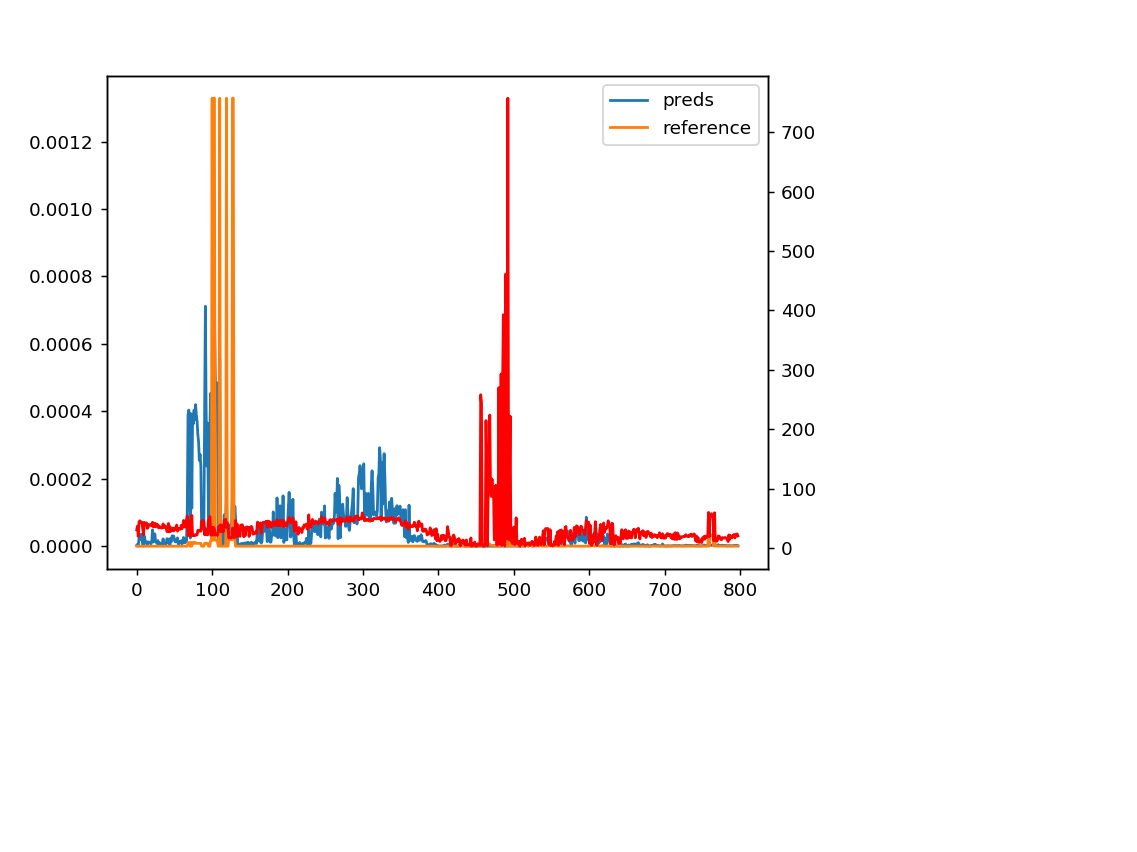

In [169]:
plt.plot(list(range(len(predictions))), prediction_norms, label='preds')
plt.plot(list(range(len(predictions))), reference_norms, label='reference')
plt.legend()
ax = plt.gca()
ax2 = ax.twinx()

ax2.plot(list(range(len(predictions))), gaussian_kl, color='red')


In [155]:
p = predictions[750]
ref = ys[validation_set[750]]

In [156]:
wishart_kl_divergence(ref, 6, p, 6)

51.031103968177916

In [157]:
p

array([[ 4.013e-07,  7.248e-08,  1.874e-08,  2.451e-08, -6.662e-08, -5.575e-11],
       [ 7.248e-08,  9.845e-07,  9.263e-08,  1.267e-07,  2.049e-08, -4.435e-09],
       [ 1.874e-08,  9.263e-08,  1.146e-07, -1.281e-08,  2.051e-08, -9.757e-09],
       [ 2.451e-08,  1.267e-07, -1.281e-08,  8.619e-08, -2.056e-08,  2.142e-08],
       [-6.662e-08,  2.049e-08,  2.051e-08, -2.056e-08,  3.900e-08, -8.761e-11],
       [-5.575e-11, -4.435e-09, -9.757e-09,  2.142e-08, -8.761e-11,  1.248e-07]], dtype=float32)

In [158]:
ref

array([[ 6.039e-08,  4.200e-09, -5.947e-09, -1.462e-10, -4.587e-09,  4.113e-10],
       [ 4.200e-09,  1.239e-08,  2.217e-09,  1.096e-09, -2.594e-10, -1.896e-10],
       [-5.947e-09,  2.217e-09,  1.030e-08,  3.607e-10,  1.207e-09,  6.554e-11],
       [-1.462e-10,  1.096e-09,  3.607e-10,  5.563e-10,  3.015e-12,  3.803e-12],
       [-4.587e-09, -2.594e-10,  1.207e-09,  3.015e-12,  1.596e-09, -8.056e-11],
       [ 4.113e-10, -1.896e-10,  6.554e-11,  3.803e-12, -8.056e-11,  2.506e-10]])

In [159]:
p - ref

array([[ 3.409e-07,  6.828e-08,  2.469e-08,  2.465e-08, -6.203e-08, -4.670e-10],
       [ 6.828e-08,  9.721e-07,  9.042e-08,  1.256e-07,  2.074e-08, -4.246e-09],
       [ 2.469e-08,  9.042e-08,  1.043e-07, -1.317e-08,  1.931e-08, -9.823e-09],
       [ 2.465e-08,  1.256e-07, -1.317e-08,  8.564e-08, -2.057e-08,  2.141e-08],
       [-6.203e-08,  2.074e-08,  1.931e-08, -2.057e-08,  3.740e-08, -7.050e-12],
       [-4.670e-10, -4.246e-09, -9.823e-09,  2.141e-08, -7.050e-12,  1.246e-07]])

In [160]:
(p - ref) / ref

array([[ 5.646e+00,  1.626e+01, -4.152e+00, -1.687e+02,  1.352e+01, -1.136e+00],
       [ 1.626e+01,  7.847e+01,  4.078e+01,  1.146e+02, -7.998e+01,  2.239e+01],
       [-4.152e+00,  4.078e+01,  1.012e+01, -3.652e+01,  1.600e+01, -1.499e+02],
       [-1.687e+02,  1.146e+02, -3.652e+01,  1.539e+02, -6.821e+03,  5.631e+03],
       [ 1.352e+01, -7.998e+01,  1.600e+01, -6.821e+03,  2.344e+01,  8.751e-02],
       [-1.136e+00,  2.239e+01, -1.499e+02,  5.631e+03,  8.751e-02,  4.970e+02]])